<center><h1>First Steps With Julia<h1></center>

Добрый день!

У нас есть еще одна вакансия в группу семантического анализа в Лаборатории Техносферы. За несколько месяцев стажировки несколько наши студентов успели принять участие в реальных проектах связанных с глубокими нейронными сетями, таких как:
- style transfer в приложении Artisto
- классификатор порно картинок
- анализ текстов при помощи LSTM сетей (чат-боты, автоответчики)
- семантический поиск по изображениям

Но проектов у нас больше, чем рук.

Мы ожидаем от студентов всего двух вещей:
- хорошее знание теории вероятности и мат.статистики
- умение писать код (python или c++)

Что дадим:
- возможность общаться с лучшими специалистами компании в области deep learning
- возможность посещать внутренний deep learning семинар в компании
- оплачиваемая стажировка в стенах вуза
- задачи в области deep learning и computer vision
- практическое применение результатов
- возможна публикация результатов в научных журналах

Порядок поступления:
- вы присылаете заявку вместе с результатом и описанием решения конкурса (в виде ipynb) https://www.kaggle.com/c/street-view-getting-started-with-julia используя tensorflow или theano
- проходите устное собеседование

Ждем ваших заявок.

<center><h3>Подключаем библиотеки</h3></center>

In [1]:
from scipy import misc
import numpy as np
import pandas as pd
import mahotas as mh
import tensorflow as tf
from __future__ import absolute_import#Python 2 and 3 compatible
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib
from skimage.io import imread
from scipy.misc import imread, imsave, imresize
import csv
%matplotlib inline

<center><h3>Задаем параметры</h3></center>

In [2]:
size = 20 #20x20 trainResized и testResized 
image_size = size*size*1 #400, channel = 1 only gray.
path=""
batch_size = 50
learning_rate = 0.005
max_steps = 1000

<center><h3>Считываем тестовую и трейновую выборку</h3></center>

In [3]:
def read_data(type_data, labels, path):
    x = np.zeros((labels.shape[0], image_size))
    for (index, idImage) in enumerate(labels["ID"]):
        file_name = "{1}/{2}.Bmp".format(path, type_data, idImage)
        img = np.array(mh.imread(file_name, as_grey=True), dtype=np.float64) 
        x[index] = img.ravel()
    return x

In [4]:
labels_train = pd.read_csv("trainLabels.csv")
labels_test = pd.read_csv("sampleSubmission.csv")
train = read_data("trainResized", labels_train, path)#read train
test = read_data("testResized", labels_test, path)#read test 

In [5]:
print('Test shape: ', test.shape)   
print('_________________________________________________________________________________________________________________')
print('Train shape: ', train.shape)  
print('_________________________________________________________________________________________________________________')
print('Train labels shape: ', labels_train.shape)
print('_________________________________________________________________________________________________________________')
print('First 5 labels: \n' , labels_train[0:5])
print('_________________________________________________________________________________________________________________')
print('Classes: ', np.unique(labels_train['Class'].values))
print('Total: ', len(np.unique(labels_train['Class'].values)), 'classes') 
unique_labels = np.unique(labels_train['Class'].values)

Test shape:  (6220, 400)
_________________________________________________________________________________________________________________
Train shape:  (6283, 400)
_________________________________________________________________________________________________________________
Train labels shape:  (6283, 2)
_________________________________________________________________________________________________________________
First 5 labels: 
    ID Class
0   1     n
1   2     8
2   3     T
3   4     I
4   5     R
_________________________________________________________________________________________________________________
Classes:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Total:  62 classes


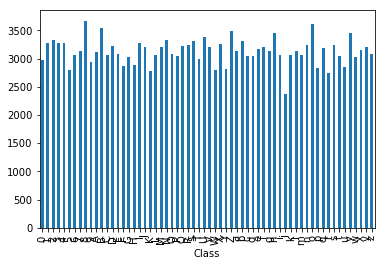

In [6]:
labels_train.groupby('Class').mean().plot(kind='bar', legend=False)
plt.show()#В среднем выборка примерно одинаково разбита по классам

<center><h3>Сделаем преобразование над лейблами</h3></center>

In [7]:
def label2int(ch):#переводит лейблы в число
    asciiVal = ord(ch)
    if(asciiVal<=57): #0-9
        asciiVal-=48
    elif(asciiVal<=90): #A-Z
        asciiVal-=55
    else: #a-z
        asciiVal-=61
    return asciiVal

In [8]:
labels_train.head()

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


In [9]:
labels_train['Class'] = labels_train['Class'].apply(label2int)

In [10]:
labels_train.head()

,ID,Class
0,1,49
1,2,8
2,3,29
3,4,18
4,5,27


In [11]:
from sklearn.preprocessing import OneHotEncoder#сделаем OneHot над 62 классами
encoder = OneHotEncoder(sparse=False)

s=set(labels_train.Class.value_counts().index)#s - все уникальные значения
key_s = range(0,61) 
d = {key: value for (key, value) in zip(sorted(s), key_s)} 
emb = labels_train.loc[:, ['Class']].replace(d).values

names=[]
for item in s:
    names.append('class %d'%item)
    
emb_enc = encoder.fit_transform(emb)

labels_train=labels_train.join(pd.DataFrame(data=emb_enc, columns=names, index=labels_train.index))

In [12]:
labels_train = labels_train.drop('Class', 1)
labels_train = labels_train.drop('ID', 1)
labels_train.head()

,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9,...,class 52,class 53,class 54,class 55,class 56,class 57,class 58,class 59,class 60,class 61
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
labels = np.array(labels_train)#сохраним в виде массива
tc = 62#количество классов будет часто использоваться в дальнейшем, сохраним

<center><h3>Зададим модель</h3></center>

Наша модель будет представлена в виде свёрточной нейронной сети, состоящей из двух слоёв.

In [14]:
images = tf.placeholder("float", shape=[None, image_size])
true_labels = tf.placeholder("float", shape=[None, tc])

In [15]:
images_reshaped = tf.reshape(images, [-1,20,20,1])

In [16]:
def weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [17]:
def conv2d(x, W):#convolutional layer
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):#pooling layer
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [18]:
W_conv1 = weight([5, 5, 1, 32])#ядро первого слоя
b_conv1 = bias([32])

In [19]:
h_conv1 = tf.nn.relu(conv2d(images_reshaped, W_conv1) + b_conv1)#нейронная функция
h_pool1 = max_pool_2x2(h_conv1)

In [20]:
W_conv2 = weight([5, 5, 32, 64])#ядро второго слоя
b_conv2 = bias([64])

In [21]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [22]:
W_fc1 = weight([5 * 5 * 64, 1024])#output
b_fc1 = bias([1024])

In [23]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 5 *5 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [24]:
keep_prob = tf.placeholder("float")#чтобы не переобучиться
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [25]:
W_fc2 = weight([1024,62])#softmax layer
b_fc2 = bias([62])

In [26]:
predicted_labels=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [37]:
cross_entropy = -tf.reduce_sum(true_labels*tf.log(predicted_labels))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(predicted_labels,1), tf.argmax(true_labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

<h3>Нормализуем данные</h3>

In [28]:
train_normed = train / train.max(axis=0)
test_normed = test / test.max(axis=0)

<h3>Запустим модель</h3>

In [40]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(5000):
    indices = np.random.choice(train.shape[0], batch_size)#чтобы ускорить делаю не со всей выборкой
    images_batch = train_normed[indices]
    labels_batch = labels[indices]
    if i%100 == 0:
        train_accuracy = sess.run( accuracy, feed_dict={ images:images_batch, true_labels: labels_batch, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    sess.run(train_step,feed_dict={images: images_batch, true_labels: labels_batch, keep_prob: 0.5})
sub_ = sess.run(predicted_labels, feed_dict={images: test_normed, keep_prob: 0.5})

step 0, training accuracy 0.02
step 100, training accuracy 0.02
step 200, training accuracy 0.14
step 300, training accuracy 0.16
step 400, training accuracy 0.24
step 500, training accuracy 0.24
step 600, training accuracy 0.3
step 700, training accuracy 0.5
step 800, training accuracy 0.38
step 900, training accuracy 0.52
step 1000, training accuracy 0.48
step 1100, training accuracy 0.5
step 1200, training accuracy 0.6
step 1300, training accuracy 0.64
step 1400, training accuracy 0.54
step 1500, training accuracy 0.58
step 1600, training accuracy 0.7
step 1700, training accuracy 0.66
step 1800, training accuracy 0.66
step 1900, training accuracy 0.74
step 2000, training accuracy 0.8
step 2100, training accuracy 0.66
step 2200, training accuracy 0.72
step 2300, training accuracy 0.66
step 2400, training accuracy 0.64
step 2500, training accuracy 0.68
step 2600, training accuracy 0.76
step 2700, training accuracy 0.68
step 2800, training accuracy 0.82
step 2900, training accuracy 0.7

<center><h3>Делаем сабмит</h3></center>

In [42]:
def int2label(i):#переводим назад в буквы
    if(i<=9): #0-9
        i+=48
    elif(i<=35): #A-Z
        i+=55
    else: #a-z
        i+=61
    return chr(i)

In [43]:
submission = pd.DataFrame()
submission['ID'] = labels_test['ID']
submission['Class'] = pd.DataFrame(np.argmax(sub_, axis=1))
submissionName = 'Successful_submission'
submission['Class'] = submission['Class'].apply(int2label)
submission.to_csv(submissionName + '.csv', index=False)

In [46]:
submission.head()

,ID,Class
0,6284,L
1,6285,E
2,6286,I
3,6287,V
4,6288,r
